In [71]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from collections import defaultdict
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from fastai.fastai.dataset import ImageClassifierData
from fastai.fastai.transforms import tfms_from_model, RandomFlip
from fastai.fastai.transforms import RandomRotate, RandomLighting
from fastai.fastai.transforms import transforms_side_on, CropType
from torchvision.models import resnet34

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lesson 9

## 00:00:01 - Object detection problem

* General approach: start simple and gradually make it more complicated.
* Last week:
  * Trained a classifier
  * Trained a bounding box detector
* This week: put the two ideas together, building up to final goal.

## 00:00:55 - Prerequisites from last week

* Concepts from last week:
  * Pathlib; JSON
  * Dictionary comprehensions
  * ``defaultdict``
  * How to jump around fastai source.
  * matplotlib OO API:

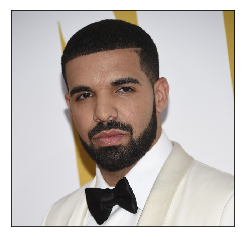

In [74]:
im = Image.open('./images/Drake-1510152261-640x619.jpg')
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax
plt.show()

  * lambda functions
  * bounding box coordinates
  * custom head; bounding box regression

## 00:01:43 - Prerequisites from Fast.ai Part 1

* Knowledge of how to print out inputs from DataLoader.
* How to view model outputs.

## 00:03:02 - Pascal notebook

Revisiting code from last lesson:

In [31]:
PATH = Path('./data/pascal/')

In [41]:
PATH.mkdir(exist_ok=True)

In [34]:
train_json = json.load((PATH / 'PASCAL_VOC' / 'pascal_train2007.json').open())
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [35]:
train_json['annotations'][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [36]:
train_json['categories'][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [37]:
categories = {cat['id']: cat['name'] for cat in train_json['categories']}

train_filenames = {img['id']: img['file_name'] for img in train_json['images']}
train_ids = [img['id'] for img in train_json['images']]

In [39]:
list((PATH / 'VOCdevkit' / 'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations')]

In [40]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [42]:
IMG_PATH = PATH / JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007666.jpg')]

Get largest bounding box for an image:

In [47]:
def get_largest(bounding_box):
    if not bounding_box:
        raise Exception()
    
    output = sorted(
        bounding_box, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return output[0]

In [55]:
def convert_to_numpy_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

train_annotations = defaultdict(lambda:[])
for o in train_json['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = convert_to_numpy_bb(bb)
        train_annotations[o['image_id']].append((bb, o['category_id']))
        
len(train_annotations)

2501

In [56]:
train_largest_annotations = {
    a: get_largest(b) for a, b in train_annotations.items()}

In [60]:
(PATH / 'tmp').mkdir(exist_ok=True)
BB_CSV = PATH / 'tmp' / 'bb.csv'

In [61]:
bb = np.array([train_largest_annotations[o] for o in train_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [train_filenames[o] for o in train_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

Create data augmentations:

In [64]:
augs = [
    RandomFlip(),
    RandomRotate(30),
    RandomLighting(0.1, 0.1)
]

In [66]:
f_model = resnet34
sz=224
bs=64

Note that `ImageClassifierData` accepts `continuous=True`, to basically turn it into a data loader for a regression problem (doesn't one-hot encode the labels). This is expected to be fixed in future versions of Fast.ai.

In [73]:
tfms = tfms_from_model(
    f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=bs)

## 00:04:46 - Data augmentations

* When we normally create data augmentations, we usually